# Qrylov

## Setup

In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import scipy as sp

import openfermion as of

import numpy as np
import openfermion as of

import cirq
import qiskit
import qiskit.qasm2
import quimb.tensor as qtn

from tensor_network_common import pauli_sum_to_mpo

## Parameters

In [2]:
xdim: int = 2
ydim: int = 4

subspace_dimension: int = 16

threshold: float = -1e-4  # Set to -np.inf to disable thresholding.

max_mpo_bond: int = 128
max_mps_bond: int = 256

alpha: float = 10.0  # The initial state is |ground state> + |random state> / alpha.

In [3]:
def fill_h_and_s_matrices(
    vectors: List[np.ndarray] | List[np.ndarray],
    mpo: qtn.MatrixProductOperator | np.ndarray,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    tensor_algebra = isinstance(mpo, qtn.MatrixProductOperator)

    dim = len(vectors)
    h = np.zeros((dim, dim), dtype=np.complex128)
    s = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(dim):
        for j in range(i, dim):
            if verbose:
                print(f"A_{i}{j}", end=" ")

            if tensor_algebra:
                hij = vectors[i].H @ mpo.apply(vectors[j])
            else:
                hij = vectors[i].conj().T @ mpo @ vectors[j]

            h[i, j] = hij
            if i != j:
                h[j, i] = np.conjugate(hij)

            if tensor_algebra:
                sij = vectors[i].H @ vectors[j]
            else:
                sij = vectors[i].conj().T @ vectors[j]
            s[i, j] = sij
            if i != j:
                s[j, i] = np.conjugate(sij)
    return h, s


# Based on https://quantum.cloud.ibm.com/docs/en/tutorials/krylov-quantum-diagonalization.
# and Algorithm 1.1 of https://arxiv.org/abs/2110.07492.
def solve_regularized_gen_eig(
    h: np.ndarray,
    s: np.ndarray,
    threshold: float = -np.inf,
) -> float:
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array(
        [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
    )
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    return sp.linalg.eigh(h_reg, s_reg)[0][0]

## Problem definition

In [4]:
hamiltonian = of.jordan_wigner(
    of.hamiltonians.fermi_hubbard(
        xdim,
        ydim,
        1.0,
        1.0,
        spinless=True
    )
)

nqubits = of.utils.count_qubits(hamiltonian)
nqubits

8

## Exact energy

In [5]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)
mpo = pauli_sum_to_mpo(hamiltonian_cirq, cirq.LineQubit.range(nqubits), max_bond=max_mpo_bond)
mpo.show()

│4│8│11│14│11│8│4│
●─<─<──<──<──<─<─<
│ │ │  │  │  │ │ │


In [6]:
dmrg = qtn.DMRG2(mpo, bond_dims=[2 ** (i + 1) for i in range(int(np.log2(max_mpo_bond)))])
dmrg.solve(verbosity=1)

energy_exact = np.real(dmrg.energy)
ground_state = dmrg.state
print("Exact energy:", energy_exact)
ground_state.show()

1, R, max_bond=(2/2), cutoff:1e-08


100%|############################################| 7/7 [00:00<00:00, 377.66it/s]

Energy: (-3.6162117585883125+6.938893903907228e-15j) ... not converged.
2, R, max_bond=(2/4), cutoff:1e-08



100%|############################################| 7/7 [00:00<00:00, 397.86it/s]

Energy: (-3.9680791016618793+6.5503158452884236e-15j) ... not converged.
3, R, max_bond=(4/8), cutoff:1e-08



100%|############################################| 7/7 [00:00<00:00, 244.49it/s]

Energy: (-4.090406070572379+7.313594174718219e-15j) ... not converged.
4, R, max_bond=(8/16), cutoff:1e-08



100%|############################################| 7/7 [00:00<00:00, 126.60it/s]

Energy: (-4.102052554748173+6.300515664747763e-15j) ... not converged.
5, R, max_bond=(11/32), cutoff:1e-08



100%|############################################| 7/7 [00:00<00:00, 171.34it/s]

Energy: (-4.102059772879972+7.13318293321663e-15j) ... converged!
Exact energy: -4.102059772879972
 2 4 8 10 8 4 2 
>─>─>─>──>─>─>─●
│ │ │ │  │ │ │ │


## Initial state

In [7]:
bvec = ground_state + qtn.MPS_rand_state(mpo.L, bond_dim=2) / alpha
bvec /= bvec.norm()
overlap = np.abs(bvec @ ground_state) ** 2
overlap

0.9872339918716356

## Krylov with $H$

In [8]:
vectors = [bvec]
for i in range(subspace_dimension - 1):
    print(i)
    new = mpo.apply(vectors[-1], compress=True, max_bond=max_mps_bond)
    print("Max bond:", new.max_bond())
    vectors.append(new)

0
Max bond: 16
1
Max bond: 16
2
Max bond: 16
3
Max bond: 16
4
Max bond: 16
5
Max bond: 16
6
Max bond: 16
7
Max bond: 16
8
Max bond: 15
9
Max bond: 15
10
Max bond: 15
11
Max bond: 14
12
Max bond: 13
13
Max bond: 13
14
Max bond: 12


In [9]:
h, s = fill_h_and_s_matrices(vectors, mpo, verbose=True)

A_00 A_01 A_02 A_03 A_04 A_05 A_06 A_07 A_08 A_09 A_010 A_011 A_012 A_013 A_014 A_015 A_11 A_12 A_13 A_14 A_15 A_16 A_17 A_18 A_19 A_110 A_111 A_112 A_113 A_114 A_115 A_22 A_23 A_24 A_25 A_26 A_27 A_28 A_29 A_210 A_211 A_212 A_213 A_214 A_215 A_33 A_34 A_35 A_36 A_37 A_38 A_39 A_310 A_311 A_312 A_313 A_314 A_315 A_44 A_45 A_46 A_47 A_48 A_49 A_410 A_411 A_412 A_413 A_414 A_415 A_55 A_56 A_57 A_58 A_59 A_510 A_511 A_512 A_513 A_514 A_515 A_66 A_67 A_68 A_69 A_610 A_611 A_612 A_613 A_614 A_615 A_77 A_78 A_79 A_710 A_711 A_712 A_713 A_714 A_715 A_88 A_89 A_810 A_811 A_812 A_813 A_814 A_815 A_99 A_910 A_911 A_912 A_913 A_914 A_915 A_1010 A_1011 A_1012 A_1013 A_1014 A_1015 A_1111 A_1112 A_1113 A_1114 A_1115 A_1212 A_1213 A_1214 A_1215 A_1313 A_1314 A_1315 A_1414 A_1415 A_1515 

In [10]:
krylov_dvals = []
krylov_evals = []
for d in range(1, len(h) + 1):
    try:
        krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
        print(d, krylov_energy)
        krylov_dvals.append(d)
        krylov_evals.append(krylov_energy)
    except np.linalg.LinAlgError:
        continue

1 -4.028792370960818
2 -4.09569244238539
3 -4.100985423550317
4 -4.10179140511931
5 -4.101970097591121
6 -4.102024882497886
7 -4.102042370159371
8 -4.102048455780384
9 -4.1020515560727215
10 -4.102053668128708
11 -4.1020564762246705
12 -4.102056756065174
13 -4.102058150479002
14 -4.102058172050735
15 -4.102058206144106


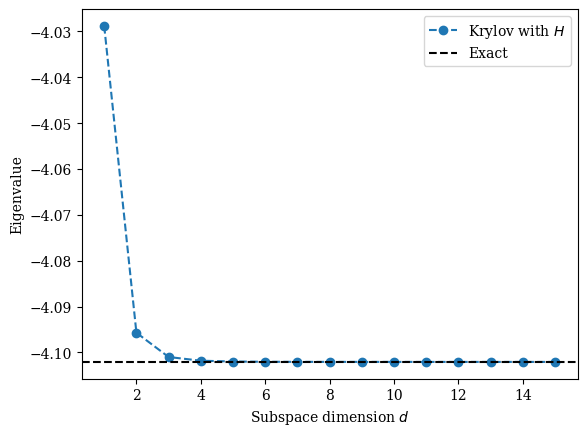

In [11]:
plt.plot(krylov_dvals, krylov_evals, "--o", label="Krylov with $H$")
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.legend();

### Unitary Krylov

In [12]:
# See Theorem 3.1 of https://arxiv.org/abs/2110.07492.
# dt = np.pi / (evals_exact[-1] - evals_exact[0])
dt = np.pi / mpo.norm()
dt

0.04363323129985816

In [13]:
if nqubits <= 10:
    matrix = mpo.to_dense()
    vec = bvec.to_dense()

    vectors_u = []
    for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
        print(k)
        Uk = sp.sparse.linalg.expm(-1j * matrix * k * dt)  # TODO: Speedup with https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.expm_multiply.html.
        vectors_u.append(Uk @ vec)


    h, s = fill_h_and_s_matrices(vectors_u, matrix, verbose=True)

    krylov_u_dvals = []
    krylov_u_evals = []
    for d in range(1, len(h)):
        try:
            krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
            print(d, krylov_energy)
            krylov_u_dvals.append(d)
            krylov_u_evals.append(krylov_energy)
        except np.linalg.LinAlgError:
            continue

-32
-31
-30
-29
-28
-27
-26
-25
-24
-23
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
A_00 A_01 A_02 A_03 A_04 A_05 A_06 A_07 A_08 A_09 A_010 A_011 A_012 A_013 A_014 A_015 A_016 A_017 A_018 A_019 A_020 A_021 A_022 A_023 A_024 A_025 A_026 A_027 A_028 A_029 A_030 A_031 A_032 A_033 A_034 A_035 A_036 A_037 A_038 A_039 A_040 A_041 A_042 A_043 A_044 A_045 A_046 A_047 A_048 A_049 A_050 A_051 A_052 A_053 A_054 A_055 A_056 A_057 A_058 A_059 A_060 A_061 A_062 A_063 A_064 A_11 A_12 A_13 A_14 A_15 A_16 A_17 A_18 A_19 A_110 A_111 A_112 A_113 A_114 A_115 A_116 A_117 A_118 A_119 A_120 A_121 A_122 A_123 A_124 A_125 A_126 A_127 A_128 A_129 A_130 A_131 A_132 A_133 A_134 A_135 A_136 A_137 A_138 A_139 A_140 A_141 A_142 A_143 A_144 A_145 A_146 A_147 A_148 A_149 A_150 A_151 A_152 A_153 A_154 A_155 A_156 A_157 A_158 A_159 A_160 A_161 A_162 A_163 A_164 A_22 A_23 A_24 A_25 A_26 A_27 A_28 A_

/tmp/ipykernel_145412/4144621074.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h[i, j] = hij
/tmp/ipykernel_145412/4144621074.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s[i, j] = sij
/tmp/ipykernel_145412/4144621074.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h[j, i] = np.conjugate(hij)
/tmp/ipykernel_145412/4144621074.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensur

## Trotterized unitary Krylov

In [14]:
def cirq_pauli_sum_to_qiskit_pauli_op(pauli_sum: cirq.PauliSum) -> qiskit.quantum_info.SparsePauliOp:
    """Returns a qiskit.SparsePauliOp representation of the cirq.PauliSum."""
    cirq_pauli_to_str = {cirq.X: "X", cirq.Y: "Y", cirq.Z: "Z"}

    qubits = pauli_sum.qubits
    terms = []
    coeffs = []
    for term in pauli_sum:
        string = ""
        for qubit in qubits:
            if qubit not in term:
                string += "I"
            else:
                string += cirq_pauli_to_str[term[qubit]]
        terms.append(string)
        assert np.isclose(term.coefficient.imag, 0.0, atol=1e-7)
        coeffs.append(term.coefficient.real)
    return qiskit.quantum_info.SparsePauliOp(terms, coeffs)

In [15]:
hamiltonian_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(hamiltonian_cirq)

In [16]:
ntrotter_values = [1, 2, 4, 8, 16, 32]
trotter_circuits = []
all_krylov_u_trotter_dvals = []
all_krylov_u_trotter_evals = []

for ntrotter in ntrotter_values:
    print("Status: ntrotter =", ntrotter)
    trotter_operation = qiskit.circuit.library.PauliEvolutionGate(
        hamiltonian_qiskit,
        time=dt,
        synthesis=qiskit.synthesis.LieTrotter(reps=ntrotter)
    )
    trotter_circuit = qiskit.QuantumCircuit(nqubits)
    trotter_circuit.append(trotter_operation, trotter_circuit.qubits)
    trotter_circuit = qiskit.transpile(
        trotter_circuit, basis_gates=["u3", "cx"]
    )  # TODO: Compile to a target backend, e.g. IBM Fez.
    print("Trotter circuit gate counts:")
    print(trotter_circuit.count_ops())

    trotter_circuits.append(trotter_circuit)

    forward = trotter_circuit.copy()
    forward_qasm = qiskit.qasm2.dumps(forward)

    reverse = trotter_circuit.inverse().copy()
    reverse_qasm = qiskit.qasm2.dumps(reverse)

    forward_vectors = [bvec]

    for k in range(2 * subspace_dimension):
        print("Forward:", k)
        new = qtn.CircuitMPS.from_openqasm2_str(
            forward_qasm, psi0=forward_vectors[-1], progbar=False, max_bond=max_mps_bond,
        ).psi
        forward_vectors.append(new)
    
    reverse_vectors = [bvec]
    for k in range(2 * subspace_dimension):
        print("Reverse:", k)
        new = qtn.CircuitMPS.from_openqasm2_str(
            reverse_qasm, psi0=reverse_vectors[-1], progbar=False, max_bond=max_mps_bond,
        ).psi
        reverse_vectors.append(new)

    _ = reverse_vectors.pop(0)
    reverse_vectors = list(reversed(reverse_vectors))

    vectors_u_trotter = reverse_vectors + forward_vectors

    h, s = fill_h_and_s_matrices(vectors_u_trotter, mpo, verbose=True)

    krylov_u_trotter_evals = []
    krylov_u_trotter_dvals = []
    for d in range(1, len(h)):
        try:
            krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
            print(f"Krylov {d} energy:", krylov_energy)
            krylov_u_trotter_dvals.append(d)
            krylov_u_trotter_evals.append(krylov_energy)
        except np.linalg.LinAlgError:
            continue
    
    all_krylov_u_trotter_dvals.append(krylov_u_trotter_dvals)
    all_krylov_u_trotter_evals.append(krylov_u_trotter_evals)
    print("\n" * 10)

Status: ntrotter = 1
Trotter circuit gate counts:
OrderedDict([('u3', 114), ('cx', 110)])
Forward: 0
Forward: 1
Forward: 2
Forward: 3
Forward: 4
Forward: 5
Forward: 6
Forward: 7
Forward: 8
Forward: 9
Forward: 10
Forward: 11
Forward: 12
Forward: 13
Forward: 14
Forward: 15
Forward: 16
Forward: 17
Forward: 18
Forward: 19
Forward: 20
Forward: 21
Forward: 22
Forward: 23
Forward: 24
Forward: 25
Forward: 26
Forward: 27
Forward: 28
Forward: 29
Forward: 30
Forward: 31
Reverse: 0
Reverse: 1
Reverse: 2
Reverse: 3
Reverse: 4
Reverse: 5
Reverse: 6
Reverse: 7
Reverse: 8
Reverse: 9
Reverse: 10
Reverse: 11
Reverse: 12
Reverse: 13
Reverse: 14
Reverse: 15
Reverse: 16
Reverse: 17
Reverse: 18
Reverse: 19
Reverse: 20
Reverse: 21
Reverse: 22
Reverse: 23
Reverse: 24
Reverse: 25
Reverse: 26
Reverse: 27
Reverse: 28
Reverse: 29
Reverse: 30
Reverse: 31
A_00 A_01 A_02 A_03 A_04 A_05 A_06 A_07 A_08 A_09 A_010 A_011 A_012 A_013 A_014 A_015 A_016 A_017 A_018 A_019 A_020 A_021 A_022 A_023 A_024 A_025 A_026 A_027 A_02

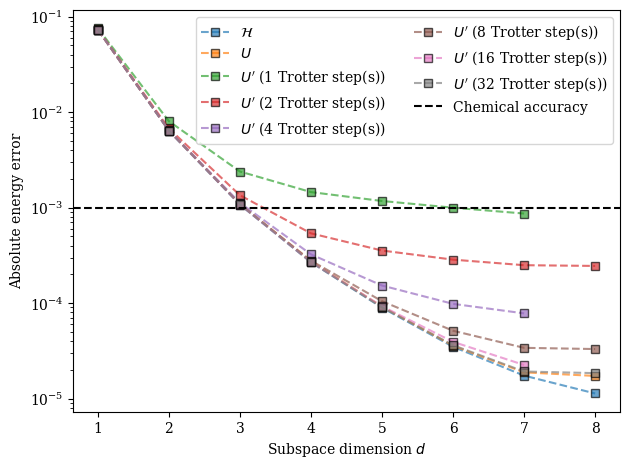

In [23]:
cutoff_ind = 8

kwargs = {"alpha": 0.6667, "mec": "black"}

# plt.figure(figsize=(8, 5))

errors_h = np.abs(np.array(krylov_evals) - energy_exact)
plt.plot(krylov_dvals[:cutoff_ind], errors_h[:cutoff_ind], "--s", label="$\mathcal{H}$", **kwargs)

if nqubits <= 10:
    errors_u = np.abs(np.array(krylov_u_evals) - energy_exact)
    plt.plot(krylov_u_dvals[:cutoff_ind], errors_u[:cutoff_ind], "--s", label="$U$", **kwargs)

for ntrotter, krylov_u_trotter_dvals, krylov_u_trotter_evals in zip(ntrotter_values, all_krylov_u_trotter_dvals, all_krylov_u_trotter_evals):
    errors_u_trotter = np.abs(np.array(krylov_u_trotter_evals) - energy_exact)
    plt.plot(krylov_u_trotter_dvals[:cutoff_ind], errors_u_trotter[:cutoff_ind], "--s", label=rf"$U'$ ({ntrotter} Trotter step(s))", **kwargs)

plt.axhline(1e-3, ls="--", color="black", label="Chemical accuracy")

# plt.title(f"{nqubits}-qubit Fermi-Hubbard Hamiltonian\nInitial state overlap with ground state = {round(overlap, 3)}")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Absolute energy error")

plt.yscale("log")
plt.legend(ncol=2) #bbox_to_anchor=(1.05, 1));
plt.tight_layout()
plt.savefig(f"krylov_hubbard_nqubits_{nqubits}_overlap_{overlap}_threshold_{threshold}.pdf")

In [18]:
ngates_oneq = []
ngates_twoq = []
depths = []

for circuit in trotter_circuits:
    counts = circuit.count_ops()
    print(counts)

OrderedDict([('u3', 114), ('cx', 110)])
OrderedDict([('u3', 228), ('cx', 220)])
OrderedDict([('u3', 456), ('cx', 440)])
OrderedDict([('u3', 912), ('cx', 880)])
OrderedDict([('u3', 1824), ('cx', 1760)])
OrderedDict([('u3', 3648), ('cx', 3520)])


In [ ]:
plt.plot(ntrotter_values, ngates_oneq, "--o", label="One-qubit gates")
plt.plot(ntrotter_values, ngates_twoq, "--o", label="Two-qubit gates")
plt.plot(ntrotter_values, depths, "--o", label="Circuit depth")

plt.xlabel("Number of Trotter steps")
plt.ylabel("Count")

plt.legend();